In [9]:
import numpy as np
import matplotlib.pyplot as plt
import gym

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [10]:
class Actor_Net(nn.Module):
    def __init__(self,n_in,n_out,action_bound):
        super(Actor_Net,self).__init__()
        self.fc1=nn.Linear(n_in,64)
        self.fc2=nn.Linear(64,32)
        self.fc3=nn.Linear(32,16)
        
        self.fc_mu=nn.Linear(16,n_out)
        self.fc_std=nn.Linear(16,n_out)
        self.action_bound=action_bound
    
    def forward(self,x):
        h1=F.relu(self.fc1(x))
        h2=F.relu(self.fc2(h1))
        h3=F.relu(self.fc3(h2))
        
        mu=F.tanh(self.fc_mu(h3))
        std=F.softplus(self.fc_std(h3))
        
        return mu*self.action_bound,std

In [11]:
class Critic_Net(nn.Module):
    def __init__(self,n_in,n_out):
        super(Critic_Net,self).__init__()
        self.fc1=nn.Linear(n_in,64)
        self.fc2=nn.Linear(64,32)
        self.fc3=nn.Linear(32,16)
        self.fc_value=nn.Linear(16,n_out)
    
    def forward(self,x):
        h1=F.relu(self.fc1(x))
        h2=F.relu(self.fc2(h1))
        h3=F.relu(self.fc3(h2))
        out=self.fc_value(h3)
        return out

In [23]:
class Actor(nn.Module):
    def __init__(self,state_dim,action_dim,action_bound,lr_rate):
        super(Actor,self).__init__()
        
        self.state_dim=state_dim
        self.std_bound=[1e-2,1.]
        self.actor_network=Actor_Net(state_dim,action_dim,action_bound)
        self.optimizer=optim.Adam(self.actor_network.parameters(),lr=lr_rate)
        
    def log_pdf(self,mu,std,action):
        std=torch.clamp(std,min=self.std_bound[0],max=self.std_bound[1])
        var=std**2
        log_policy_pdf=-0.5*(action-mu)**2/var-0.5*torch.log(var*2*np.pi)
        return torch.sum(log_policy_pdf,dim=1,keepdim=True)
    
    def get_action(self,state):
        self.actor_network.eval()
        with torch.no_grad():
            mu_a,std_a=self.actor_network(state.view(1,self.state_dim))
            mu_a,std_a=mu_a[0],std_a[0]
            sta_a=torch.clamp(std_a,self.std_bound[0],self.std_bound[1])
            action=torch.normal(mu_a,std_a)
        return action
    
    def update(self,states,actions,advantages):
        self.actor_network.train()
        mu_a,std_a=self.actor_network(states)
        log_policy_pdf=self.log_pdf(mu_a,std_a,actions)
        loss=torch.sum(-log_policy_pdf*advantages.detach())
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [24]:
class Critic(nn.Module):
    def __init__(self,state_dim,lr_rate):
        super(Critic,self).__init__()
        
        self.critic_network=Critic_Net(state_dim,1)
        self.optimizer=optim.Adam(self.critic_network.parameters(),lr=lr_rate)
        
    def get_value(self,states):
        self.critic_network.eval()
        value=self.critic_network(states)
        return value
    
    def update(self,states,targets):
        self.critic_network.train()
        values=self.critic_network(states)
        loss=F.mse_loss(values,targets.detach())
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [31]:
class Agent:
    def __init__(self,env):
        self.gamma=0.95
        self.batch_size=32
        self.actor_lr_rate=0.0001
        self.critic_lr_rate=0.001
        self.env=env
        
        self.state_dim=env.observation_space.shape[0]
        self.action_dim=env.action_space.shape[0]
        self.action_bound=env.action_space.high[0]
        
        self.actor=Actor(self.state_dim,self.action_dim,self.action_bound,self.actor_lr_rate)
        self.critic=Critic(self.state_dim,self.critic_lr_rate)
        self.save_epi_reward=[]
    
    def advantage_td_target(self,reward,v_value,next_v_value,done):
        if done:
            y_k=reward
            advantage=y_k-v_value
        else:
            y_k=reward+self.gamma*next_v_value
            advantage=y_k-v_value
        return advantage,y_k
    
    def unpack_batch(self,batch):
        unpack=[]
        for idx in range(len(batch)):
            unpack.append(batch[idx])
        unpack=torch.cat(unpack,axis=0)
        return unpack
    
    def train(self,max_episode_num):
        for ep in range(max_episode_num):
            batch_state,batch_action,batch_td_target,batch_advantage=[],[],[],[]
            time, episode_reward, done = 0, 0, False
            state=self.env.reset()
            state=torch.from_numpy(state).type(torch.FloatTensor)
            
            while not done:
                action=self.actor.get_action(state)
                action=np.array([action.item()])
                action=np.clip(action,-self.action_bound,self.action_bound)
                
                next_state,reward,done,_=self.env.step(action)
                
                next_state=torch.from_numpy(next_state).type(torch.FloatTensor)
                action=torch.from_numpy(action).type(torch.FloatTensor)
                reward=torch.FloatTensor([reward])
                
                state= state.view(1, self.state_dim)
                next_state= next_state.view(1, self.state_dim)
                action= action.view(1, self.action_dim)
                reward= reward.view(1, 1)
                
                v_value=self.critic.get_value(state)
                next_v_value=self.critic.get_value(next_state)
                
                train_reward=(reward+8)/8
                advantage,y_i=self.advantage_td_target(train_reward,v_value,next_v_value,done)
                
                batch_state.append(state)
                batch_action.append(action)
                batch_td_target.append(y_i)
                batch_advantage.append(advantage)
                
                if len(batch_state)<self.batch_size:
                    state=next_state[0]
                    episode_reward+=reward[0]
                    time+=1
                    continue
                
                states=self.unpack_batch(batch_state)
                actions=self.unpack_batch(batch_action)
                td_targets=self.unpack_batch(batch_td_target)
                advantages=self.unpack_batch(batch_advantage)
                
                batch_state, batch_action, batch_td_target, batch_advantage = [],[],[],[]
                
                self.critic.update(states,td_targets)
                self.actor.update(states,actions,advantages)
                
                state=next_state[0]
                episode_reward+=reward[0]
                time+=1
            self.save_epi_reward.append(episode_reward.item())
            if len(self.save_epi_reward) < 20:      
                print('Episode:', ep+1, 'Time:', time, 'Reward(ave of recent20):', np.mean(self.save_epi_reward))
            else:
                print('Episode:', ep+1, 'Time:', time, 'Reward(ave of recent20):', np.mean(self.save_epi_reward[-20:]))
                
    def plot_result(self):
        plt.plot(self.save_epi_reward)
        plt.show()

Episode: 1 Time: 200 Reward(ave of recent20): -1197.9102783203125
Episode: 2 Time: 200 Reward(ave of recent20): -1156.1196899414062
Episode: 3 Time: 200 Reward(ave of recent20): -1328.196533203125
Episode: 4 Time: 200 Reward(ave of recent20): -1429.2102966308594
Episode: 5 Time: 200 Reward(ave of recent20): -1498.1064208984376
Episode: 6 Time: 200 Reward(ave of recent20): -1534.7075805664062
Episode: 7 Time: 200 Reward(ave of recent20): -1521.667271205357
Episode: 8 Time: 200 Reward(ave of recent20): -1460.2749786376953
Episode: 9 Time: 200 Reward(ave of recent20): -1492.3960367838542
Episode: 10 Time: 200 Reward(ave of recent20): -1430.5767150878905
Episode: 11 Time: 200 Reward(ave of recent20): -1394.2920532226562
Episode: 12 Time: 200 Reward(ave of recent20): -1379.0406443277996
Episode: 13 Time: 200 Reward(ave of recent20): -1344.7966167743389
Episode: 14 Time: 200 Reward(ave of recent20): -1344.2352774483818
Episode: 15 Time: 200 Reward(ave of recent20): -1378.100948079427
Episode

Episode: 124 Time: 200 Reward(ave of recent20): -1271.2004333496093
Episode: 125 Time: 200 Reward(ave of recent20): -1277.4309875488282
Episode: 126 Time: 200 Reward(ave of recent20): -1271.9449829101563
Episode: 127 Time: 200 Reward(ave of recent20): -1271.6842346191406
Episode: 128 Time: 200 Reward(ave of recent20): -1279.3705627441407
Episode: 129 Time: 200 Reward(ave of recent20): -1296.0789672851563
Episode: 130 Time: 200 Reward(ave of recent20): -1298.211651611328
Episode: 131 Time: 200 Reward(ave of recent20): -1295.6372131347657
Episode: 132 Time: 200 Reward(ave of recent20): -1300.1329528808594
Episode: 133 Time: 200 Reward(ave of recent20): -1304.2677124023437
Episode: 134 Time: 200 Reward(ave of recent20): -1293.086767578125
Episode: 135 Time: 200 Reward(ave of recent20): -1293.522021484375
Episode: 136 Time: 200 Reward(ave of recent20): -1292.4056030273437
Episode: 137 Time: 200 Reward(ave of recent20): -1298.2369201660156
Episode: 138 Time: 200 Reward(ave of recent20): -12

Episode: 246 Time: 200 Reward(ave of recent20): -1282.8627685546876
Episode: 247 Time: 200 Reward(ave of recent20): -1277.2650817871095
Episode: 248 Time: 200 Reward(ave of recent20): -1276.790020751953
Episode: 249 Time: 200 Reward(ave of recent20): -1269.7024169921874
Episode: 250 Time: 200 Reward(ave of recent20): -1264.4242919921876
Episode: 251 Time: 200 Reward(ave of recent20): -1261.4582458496093
Episode: 252 Time: 200 Reward(ave of recent20): -1258.2221923828124
Episode: 253 Time: 200 Reward(ave of recent20): -1258.315692138672
Episode: 254 Time: 200 Reward(ave of recent20): -1261.5231201171875
Episode: 255 Time: 200 Reward(ave of recent20): -1253.1770263671874
Episode: 256 Time: 200 Reward(ave of recent20): -1251.6169128417969
Episode: 257 Time: 200 Reward(ave of recent20): -1249.097607421875
Episode: 258 Time: 200 Reward(ave of recent20): -1245.3253784179688
Episode: 259 Time: 200 Reward(ave of recent20): -1250.9319152832031
Episode: 260 Time: 200 Reward(ave of recent20): -12

Episode: 368 Time: 200 Reward(ave of recent20): -1178.5077758789062
Episode: 369 Time: 200 Reward(ave of recent20): -1180.966552734375
Episode: 370 Time: 200 Reward(ave of recent20): -1179.2292724609374
Episode: 371 Time: 200 Reward(ave of recent20): -1184.0949401855469
Episode: 372 Time: 200 Reward(ave of recent20): -1179.6423950195312
Episode: 373 Time: 200 Reward(ave of recent20): -1177.015118408203
Episode: 374 Time: 200 Reward(ave of recent20): -1179.5226440429688
Episode: 375 Time: 200 Reward(ave of recent20): -1184.0300903320312
Episode: 376 Time: 200 Reward(ave of recent20): -1185.148175048828
Episode: 377 Time: 200 Reward(ave of recent20): -1175.3124298095704
Episode: 378 Time: 200 Reward(ave of recent20): -1173.1884185791016
Episode: 379 Time: 200 Reward(ave of recent20): -1178.238998413086
Episode: 380 Time: 200 Reward(ave of recent20): -1180.914389038086
Episode: 381 Time: 200 Reward(ave of recent20): -1184.4279754638671
Episode: 382 Time: 200 Reward(ave of recent20): -1177

Episode: 490 Time: 200 Reward(ave of recent20): -982.872183227539
Episode: 491 Time: 200 Reward(ave of recent20): -983.5618530273438
Episode: 492 Time: 200 Reward(ave of recent20): -979.2088775634766
Episode: 493 Time: 200 Reward(ave of recent20): -992.487271118164
Episode: 494 Time: 200 Reward(ave of recent20): -1011.724365234375
Episode: 495 Time: 200 Reward(ave of recent20): -1029.3548278808594
Episode: 496 Time: 200 Reward(ave of recent20): -1037.6223999023437
Episode: 497 Time: 200 Reward(ave of recent20): -1051.0501403808594
Episode: 498 Time: 200 Reward(ave of recent20): -1034.9260986328125
Episode: 499 Time: 200 Reward(ave of recent20): -1031.1107116699218
Episode: 500 Time: 200 Reward(ave of recent20): -1021.2651733398437
Episode: 501 Time: 200 Reward(ave of recent20): -1006.8940704345703
Episode: 502 Time: 200 Reward(ave of recent20): -999.7968963623047
Episode: 503 Time: 200 Reward(ave of recent20): -1011.2709686279297
Episode: 504 Time: 200 Reward(ave of recent20): -987.076

Episode: 613 Time: 200 Reward(ave of recent20): -906.8651275634766
Episode: 614 Time: 200 Reward(ave of recent20): -886.3279022216797
Episode: 615 Time: 200 Reward(ave of recent20): -867.6511169433594
Episode: 616 Time: 200 Reward(ave of recent20): -862.0196228027344
Episode: 617 Time: 200 Reward(ave of recent20): -867.9553802490234
Episode: 618 Time: 200 Reward(ave of recent20): -869.2890716552735
Episode: 619 Time: 200 Reward(ave of recent20): -858.0607604980469
Episode: 620 Time: 200 Reward(ave of recent20): -835.5360473632812
Episode: 621 Time: 200 Reward(ave of recent20): -836.0303649902344
Episode: 622 Time: 200 Reward(ave of recent20): -821.8605926513671
Episode: 623 Time: 200 Reward(ave of recent20): -817.6272247314453
Episode: 624 Time: 200 Reward(ave of recent20): -818.59228515625
Episode: 625 Time: 200 Reward(ave of recent20): -804.708383178711
Episode: 626 Time: 200 Reward(ave of recent20): -797.8446319580078
Episode: 627 Time: 200 Reward(ave of recent20): -788.058877563476

Episode: 736 Time: 200 Reward(ave of recent20): -755.4080749511719
Episode: 737 Time: 200 Reward(ave of recent20): -717.9579483032227
Episode: 738 Time: 200 Reward(ave of recent20): -671.9518768310547
Episode: 739 Time: 200 Reward(ave of recent20): -637.3748168945312
Episode: 740 Time: 200 Reward(ave of recent20): -603.4580444335937
Episode: 741 Time: 200 Reward(ave of recent20): -574.9996337890625
Episode: 742 Time: 200 Reward(ave of recent20): -533.5602882385253
Episode: 743 Time: 200 Reward(ave of recent20): -533.3933876037597
Episode: 744 Time: 200 Reward(ave of recent20): -519.0327674865723
Episode: 745 Time: 200 Reward(ave of recent20): -512.4474082946778
Episode: 746 Time: 200 Reward(ave of recent20): -502.2108238220215
Episode: 747 Time: 200 Reward(ave of recent20): -521.4299003601075
Episode: 748 Time: 200 Reward(ave of recent20): -541.7462455749512
Episode: 749 Time: 200 Reward(ave of recent20): -561.6838798522949
Episode: 750 Time: 200 Reward(ave of recent20): -574.938294219

Episode: 859 Time: 200 Reward(ave of recent20): -370.28228704929353
Episode: 860 Time: 200 Reward(ave of recent20): -370.09969732761385
Episode: 861 Time: 200 Reward(ave of recent20): -376.6767893075943
Episode: 862 Time: 200 Reward(ave of recent20): -377.706156373024
Episode: 863 Time: 200 Reward(ave of recent20): -375.265677857399
Episode: 864 Time: 200 Reward(ave of recent20): -374.4168955087662
Episode: 865 Time: 200 Reward(ave of recent20): -354.63910315036776
Episode: 866 Time: 200 Reward(ave of recent20): -354.4653574228287
Episode: 867 Time: 200 Reward(ave of recent20): -374.0241525888443
Episode: 868 Time: 200 Reward(ave of recent20): -380.6929758310318
Episode: 869 Time: 200 Reward(ave of recent20): -365.6492647409439
Episode: 870 Time: 200 Reward(ave of recent20): -365.6580836236477
Episode: 871 Time: 200 Reward(ave of recent20): -359.69412488341334
Episode: 872 Time: 200 Reward(ave of recent20): -352.7919924676418
Episode: 873 Time: 200 Reward(ave of recent20): -359.4100661

Episode: 981 Time: 200 Reward(ave of recent20): -297.3927575141191
Episode: 982 Time: 200 Reward(ave of recent20): -264.95194559395316
Episode: 983 Time: 200 Reward(ave of recent20): -252.09077005684375
Episode: 984 Time: 200 Reward(ave of recent20): -259.75468912422656
Episode: 985 Time: 200 Reward(ave of recent20): -247.70179910957813
Episode: 986 Time: 200 Reward(ave of recent20): -273.43737955391407
Episode: 987 Time: 200 Reward(ave of recent20): -265.95655298531057
Episode: 988 Time: 200 Reward(ave of recent20): -259.4718819648027
Episode: 989 Time: 200 Reward(ave of recent20): -253.3224411994219
Episode: 990 Time: 200 Reward(ave of recent20): -250.32621774971486
Episode: 991 Time: 200 Reward(ave of recent20): -231.30291138887407
Episode: 992 Time: 200 Reward(ave of recent20): -237.352439892292
Episode: 993 Time: 200 Reward(ave of recent20): -230.91895709633826
Episode: 994 Time: 200 Reward(ave of recent20): -237.80124469399453
Episode: 995 Time: 200 Reward(ave of recent20): -238.

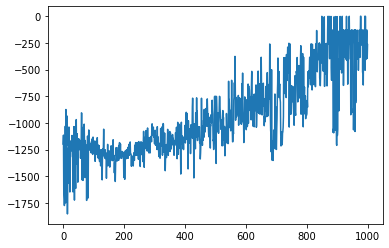

In [32]:
max_episode_num=1000
env_name='Pendulum-v0'
env=gym.make(env_name)
agent=Agent(env)
agent.train(max_episode_num)
agent.plot_result()